In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from figaro.utils import rejection_sampler
from figaro.cosmology import Planck18 as Omega, dVdz_approx_planck18
import matplotlib.pyplot as plt
import os
from corner import corner

In [3]:
true_H0 = 70. # km/s/Mpc

In [4]:
# Mass distribution
from population_models.mass import plpeak

# Luminoisty distance distribution
dL_max = 15000
def dLsq(dL):
    return 3*dL**2/dL_max**3

In [5]:
# Generate true detector frame mass samples
def generate_true_mz(n_SE_draws):
    M  = rejection_sampler(n_SE_draws, plpeak, [0,200])
    dL = rejection_sampler(n_SE_draws, dLsq, [0,dL_max])
    z = Omega.Redshift(dL)
    return np.array([M * (1 + z), dL]).T

In [6]:
# Generate detector frame mass posterior samples
def generate_posterior_samples(truth, sigma = 0.03, n_samples = 1000, limit_bounds = [100, 3000]):
    log_obs_mean = np.log(truth) + np.random.normal(0, sigma, truth.shape) # shape = (n_events, n_params)
    return np.exp(np.random.normal(log_obs_mean, sigma, (n_samples, truth.shape[0], truth.shape[1]))).transpose(1,0,2) # shape = (n_events, n_samples, n_params)

In [7]:
from selection_function import selection_function

n_SE_draws = 50000
outdir = 'hierarchical_SE_test_1'
if not os.path.exists(outdir):
    os.makedirs(outdir)

samples = generate_true_mz(n_SE_draws)
samples_SE = samples[np.random.uniform(0,1,samples.shape[0]) <= selection_function(samples)]
posterior = generate_posterior_samples(samples_SE)

samples.shape, posterior.shape

/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:29: RuntimeWarning: divide by zero encountered in power
  p = m**-alpha * (alpha-1.)/(mmin**(1.-alpha)-mmax**(1.-alpha))
/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


((50000, 2), (149, 1000, 2))

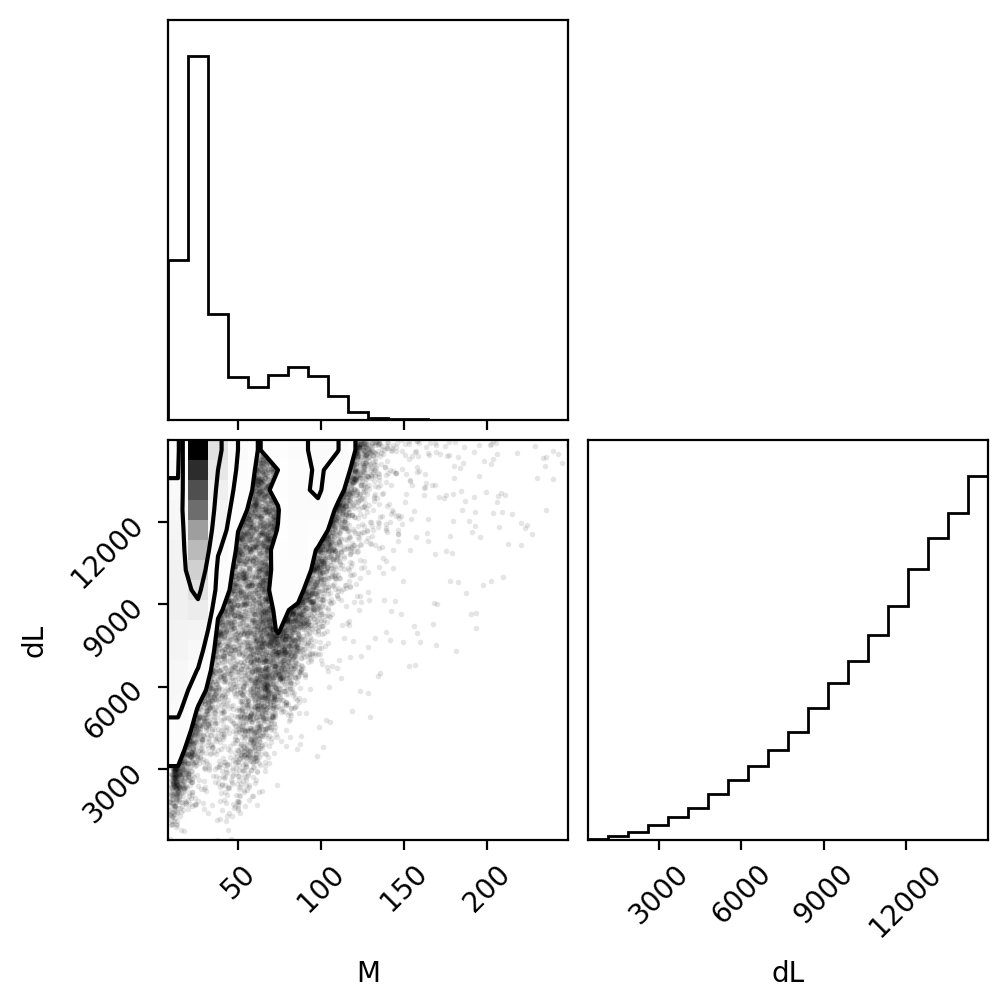

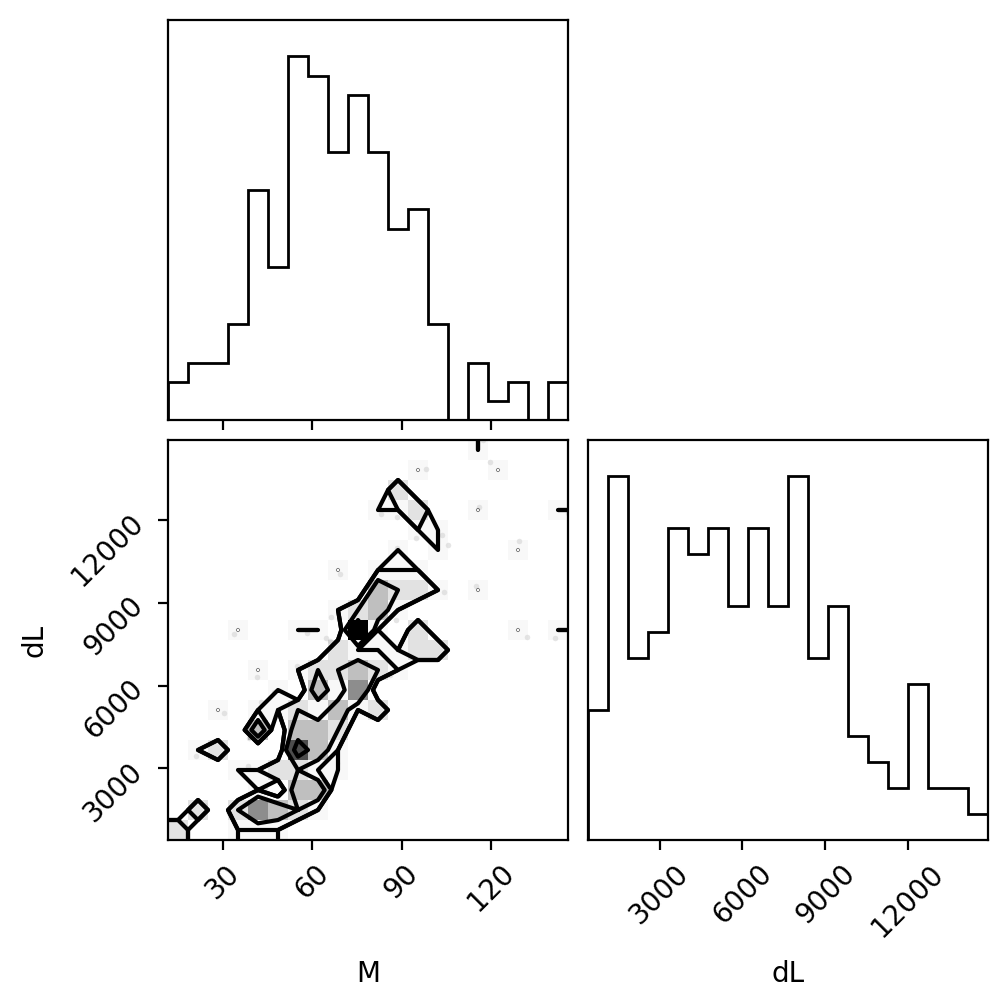

In [8]:
corner(samples, labels=['M', 'dL'])
plt.show()
corner(samples_SE, labels=['M', 'dL'])
plt.show()

In [9]:
posterior.max(axis=(0,1))

array([  158.14605705, 16536.72170082])

In [10]:
np.savetxt(outdir+'/true_samples.txt', samples)

In [11]:
np.savetxt(outdir+'/jsd_bounds.txt', np.array([np.median(posterior, axis=1).min(axis=0), np.median(posterior, axis=1).max(axis=0)]).transpose())

In [12]:
if not os.path.exists(outdir+'/data'):
    os.makedirs(outdir+'/data')
for i,p in enumerate(posterior):
    np.savetxt(f'{outdir}/data/posterior_samples_{i+1}.txt', p)